   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 4.9 MB/s eta 0:00:00
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features for training data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━

HMM Accuracy: 0.10


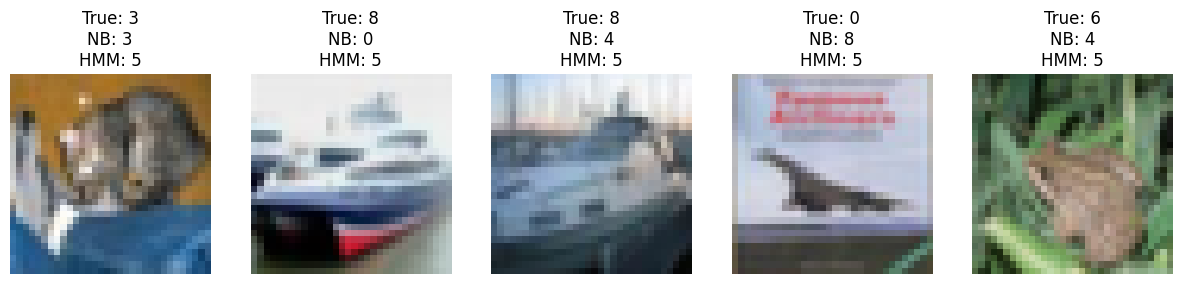

In [ ]:
# Install necessary libraries (Run this cell in Jupyter Notebook if needed)
# Uncomment the following line if hmmlearn is not installed
# !pip install tensorflow scikit-learn hmmlearn
!pip install hmmlearn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from hmmlearn import hmm  # Hidden Markov Model library

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Reduce the dataset size to speed up execution
X_train, X_test = X_train[:500], X_test[:500]  # Subset of 500 images
y_train, y_test = y_train[:500], y_test[:500]  # Corresponding labels

# Flatten the labels for compatibility
y_train = y_train.flatten()
y_test = y_test.flatten()

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Load VGG16 model (without the top layer)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Function to extract features from images
def extract_features(images):
    features = []
    for img in images:
        img = img.astype('float32') / 255.0  # Normalize pixel values
        img_array = preprocess_input(img)   # Preprocess for VGG16
        feature = vgg_model.predict(np.expand_dims(img_array, axis=0))
        features.append(feature.flatten())  # Flatten to a 1D feature array
    return np.array(features)

# Extract features from training and testing data
print("Extracting features for training data...")
X_train_features = extract_features(X_train)

print("Extracting features for testing data...")
X_test_features = extract_features(X_test)

# Reduce dimensionality using PCA
print("Reducing dimensionality with PCA...")
pca = PCA(n_components=50)  # Reduce to 50 components
X_train_features_pca = pca.fit_transform(X_train_features)
X_test_features_pca = pca.transform(X_test_features)

# Train a Naive Bayes model
print("Training Naive Bayes model...")
nb_model = GaussianNB()
nb_model.fit(X_train_features_pca, y_train_encoded)

# Predict with the Naive Bayes model
print("Predicting with Naive Bayes model...")
y_pred_nb = nb_model.predict(X_test_features_pca)

# Evaluate Naive Bayes model accuracy
accuracy_nb = accuracy_score(y_test_encoded, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

# Train a Hidden Markov Model (HMM)
print("Training Hidden Markov Model...")
# Flatten features for HMM
X_hmm = X_train_features_pca.reshape(len(X_train_features_pca), -1)

# Initialize and fit the HMM model
model_hmm = hmm.GaussianHMM(n_components=10, covariance_type='full', n_iter=100)  # Adjusted parameters
model_hmm.fit(X_hmm)

# Predict with the HMM model
X_test_hmm = X_test_features_pca.reshape(len(X_test_features_pca), -1)  # Flatten test data for HMM
y_pred_hmm = model_hmm.predict(X_test_hmm)

# Map HMM predictions to closest labels
y_pred_hmm = label_encoder.inverse_transform(y_pred_hmm)  # Map to original labels
accuracy_hmm = accuracy_score(y_test, y_pred_hmm)
print(f'HMM Accuracy: {accuracy_hmm:.2f}')

# Display images with predictions
def display_images_with_predictions(X_images, y_true, y_pred_nb, y_pred_hmm, index_range=5):
    plt.figure(figsize=(15, 5))
    for i in range(index_range):
        plt.subplot(1, index_range, i+1)
        plt.imshow(X_images[i])
        plt.title(f"True: {label_encoder.inverse_transform([y_true[i]])[0]}\n"
                  f"NB: {label_encoder.inverse_transform([y_pred_nb[i]])[0]}\n"
                  f"HMM: {label_encoder.inverse_transform([y_pred_hmm[i]])[0]}")
        plt.axis('off')
    plt.show()

# Display predictions for the first few images
display_images_with_predictions(X_test, y_test, y_pred_nb, y_pred_hmm, index_range=5)
